In [1]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


In [2]:
from alpha_vantage.timeseries import TimeSeries

API_key = "AAX6QCWZGFTK11MX"

ts = TimeSeries(key = API_key,output_format='pandas')

data = ts.get_intraday('SPY', interval = '5min')
data

(                      1. open   2. high    3. low  4. close  5. volume
 date                                                                  
 2021-04-23 20:00:00  416.2100  416.2800  416.2100  416.2500     5417.0
 2021-04-23 19:55:00  416.1900  416.2500  416.1800  416.2100     3515.0
 2021-04-23 19:50:00  416.1800  416.2000  416.1800  416.2000     1219.0
 2021-04-23 19:45:00  416.1800  416.2000  416.1700  416.1700      960.0
 2021-04-23 19:40:00  416.1800  416.1900  416.1800  416.1900      613.0
 ...                       ...       ...       ...       ...        ...
 2021-04-23 12:00:00  416.4400  416.4700  416.2400  416.2505   357532.0
 2021-04-23 11:55:00  416.4300  416.4700  416.3000  416.4400   304023.0
 2021-04-23 11:50:00  416.1550  416.4750  416.1400  416.4350  1024802.0
 2021-04-23 11:45:00  416.1892  416.2601  416.0150  416.1600   496152.0
 2021-04-23 11:40:00  416.2150  416.2800  416.1501  416.1892   620402.0
 
 [100 rows x 5 columns],
 {'1. Information': 'Intraday (5min) 

### Logistic_Regression

In [3]:
#Import required libraries

from datetime import date
today = date.today()

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [4]:
#download stock data

#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [5]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], start=date_start, end=date_end, data_source='yahoo')
    name = stock[i]
    
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
    
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [6]:
# retreive adjusted close for the SPY

combined_data

,SPY
Date,
1993-01-29,25.884184
1993-02-01,26.068277
1993-02-02,26.123499
1993-02-03,26.399649
1993-02-04,26.510111
...,...
2021-04-19,415.209991
2021-04-20,412.170013
2021-04-21,416.070007


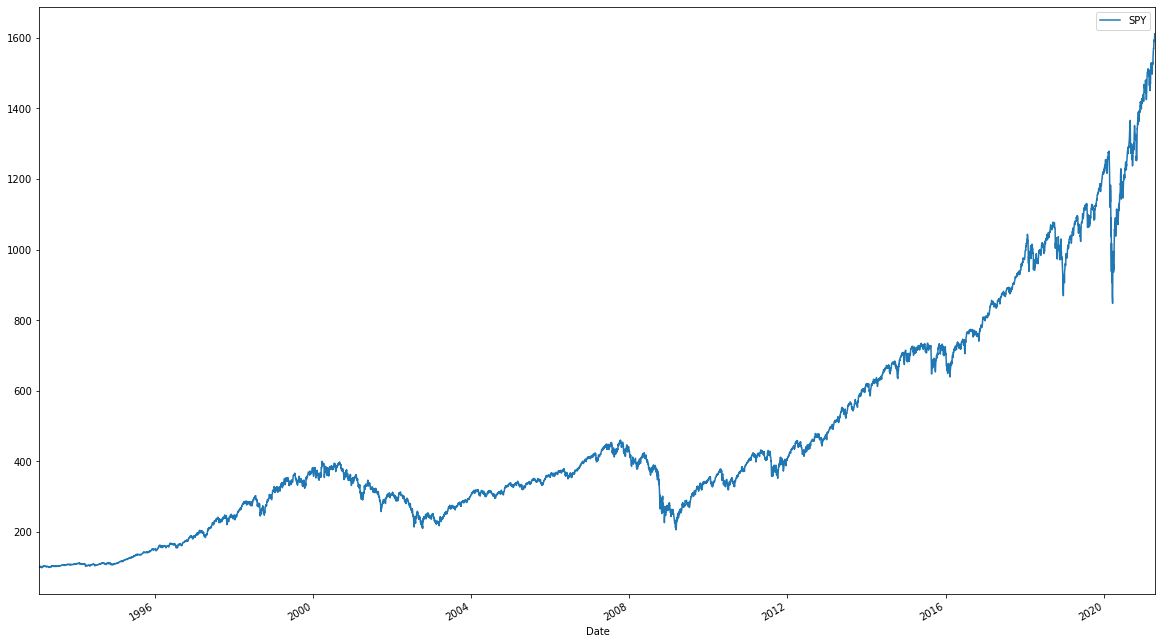

In [7]:
# SPY ETF visualization

(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [8]:
# calculate the log returns, and from this, 
# the direction on whether the return was positive or negative.
# PREDICT THE DIRECTION

combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.tail() # print the tail

,SPY,return,direction
Date,,,
2021-04-19,415.209991,-0.004925,0
2021-04-20,412.170013,-0.007348,0
2021-04-21,416.070007,0.009418,1
2021-04-22,412.269989,-0.009175,0
2021-04-23,416.739990,0.010784,1


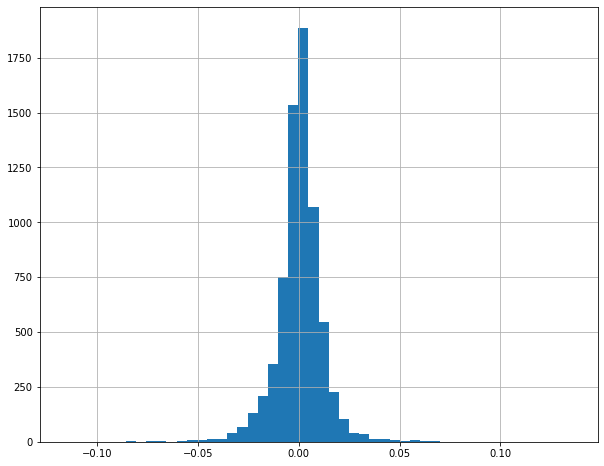

In [9]:
# histogram of the log returns for the SPY 
# gives a fairly log normal distribution.

combined_data['return'].hist(bins=50, figsize=(10, 8));

#### Feature Engineering

In [10]:
# The first feature we can add is to lag the target that we want to predict, 
# by different periods. First we apply lags of 5 periods.

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

#### apply various technical indicators (apply Bollinger Bands and MACD)

In [11]:
#pip install tensortrade[talib]
# pip install --upgrade ta

##### (BollingerBands) - Price envelopes define upper and lower price range levels.
##### (MACD) - use for revealing changes in the strength, direction, momentum, and duration of a trend in a stock's price.

In [12]:
import ta
from ta.volatility import BollingerBands # apply Bollinger Bands indicator

In [13]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
combined_data['bb_bbm'] = indicator_bb.bollinger_mavg()
combined_data['bb_bbh'] = indicator_bb.bollinger_hband()
combined_data['bb_bbl'] = indicator_bb.bollinger_lband()

In [14]:
from ta.trend import MACD # apply MACD indicator

In [15]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
combined_data['macd'] = indicator_macd.macd()
combined_data['macd_diff'] = indicator_macd.macd_diff()
combined_data['macd_signal'] = indicator_macd.macd_signal()

#### add momentum, volatility and distance indicators to the feature set.

#####  (momentum)  - measures the rate of the rise or fall of stock prices.
##### (volatility) - way to find overall market conditions for short term and long term trading.
##### (distance) - Forex Distance is a mt4 (MetaTrader 4.  it can be used with any forex trading systems / strategies for additional confirmation of trading entries or exits

In [16]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)

In [17]:
combined_data.dropna(inplace=True)

combined_data  # The final shape of the data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.339361,-0.000702,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.492891,26.906174,26.079607,-0.014643,-0.012869,-0.001773,-0.002094,0.006664,-0.043963
1993-04-22,26.006426,-0.012721,0,-0.000702,-0.004900,-0.004181,0.000000,0.000000,26.465146,26.927874,26.002418,-0.049952,-0.038543,-0.011409,-0.001957,0.006641,-0.059425
1993-04-23,25.895456,-0.004276,0,-0.012721,-0.000702,-0.004900,-0.004181,0.000000,26.423528,26.931761,25.915296,-0.085898,-0.059591,-0.026307,-0.004501,0.007186,-0.386337
1993-04-26,25.691980,-0.007889,0,-0.004276,-0.012721,-0.000702,-0.004900,-0.004181,26.379137,26.972909,25.785364,-0.129314,-0.082406,-0.046908,-0.005356,0.007006,-0.488327
1993-04-27,25.969440,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000702,-0.004900,26.343068,26.944320,25.741816,-0.139722,-0.074251,-0.065471,-0.006098,0.007095,-0.676177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,415.209991,-0.004925,0,0.003337,0.010685,-0.003421,0.002959,0.000365,403.305498,422.400404,384.210592,6.983807,0.940085,6.043723,0.002785,0.006415,23.863994
2021-04-20,412.170013,-0.007348,0,-0.004925,0.003337,0.010685,-0.003421,0.002959,404.284499,423.086977,385.482020,6.644678,0.480764,6.163914,0.001727,0.006581,21.208361
2021-04-21,416.070007,0.009418,1,-0.007348,-0.004925,0.003337,0.010685,-0.003421,405.612999,423.793673,387.432325,6.614366,0.360362,6.254004,-0.000335,0.006882,17.653869


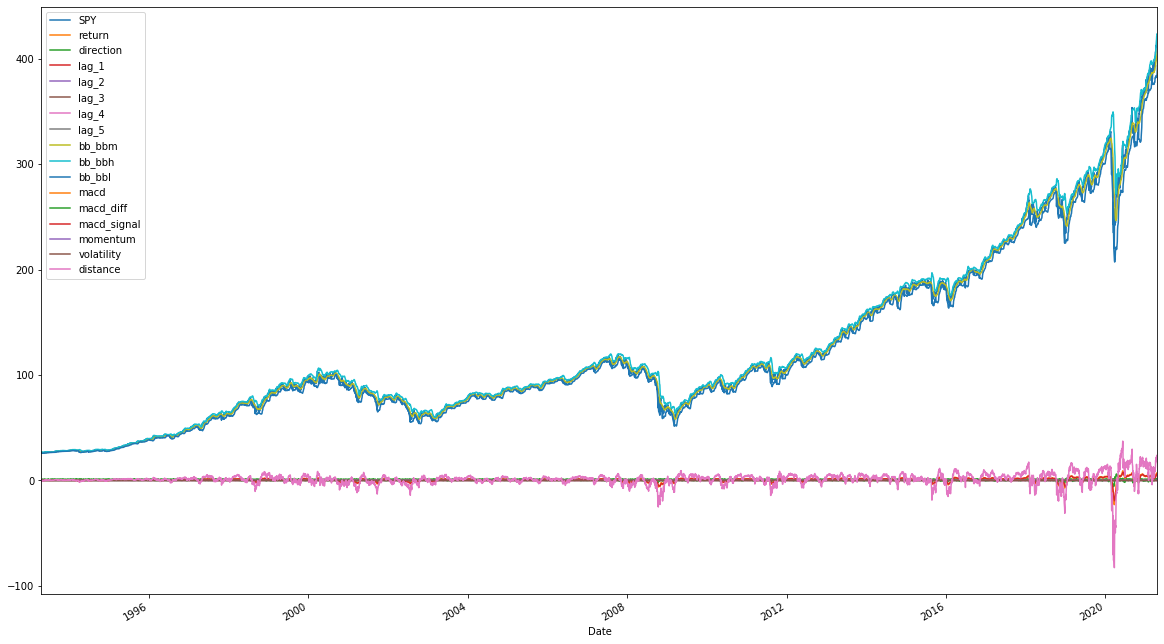

In [18]:
# visualise the added features in the plot

combined_data.plot(figsize=(20, 12))

### Modelling - Logistic Regression (using classic regression, and logistic variety due to the binary nature)

In [19]:
# select the columns to train the model on from our combined_data data frame.

cols = list(combined_data.columns)
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm',
 'bb_bbh',
 'bb_bbl',
 'macd',
 'macd_diff',
 'macd_signal',
 'momentum',
 'volatility',
 'distance']

In [20]:
# split the training and test sets to 70:30 split

X = combined_data[cols]
y = combined_data['direction']
split = int(0.7*len(combined_data))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

####  train the model

In [21]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [22]:
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs',multi_class='auto',max_iter=10000)
model = model.fit (X_train,y_train)
model.score(X_test, y_test)

# accuracy of 64% on the training set, the result is reasonable

0.6452527161076995

In [23]:
# apply cross validation using the library from ScikitLearn.

cross_val = cross_val_score(linear_model.LogisticRegression(), X, y, scoring='accuracy', cv=10)
cross_val
cross_val.mean()

D:\Dell\Workshop\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Dell\Workshop\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Dell\Workshop\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Dell\Workshop\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Dell\Workshop\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Dell\Wo

0.6325485288436776

In [24]:
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm,bb_bbh,bb_bbl,macd,macd_diff,macd_signal,momentum,volatility,distance
Date,,,,,,,,,,,,,,,,,
1993-04-21,26.339361,-0.000702,0,-0.004900,-0.004181,0.000000,0.000000,-0.001390,26.492891,26.906174,26.079607,-0.014643,-0.012869,-0.001773,-0.002094,0.006664,-0.043963
1993-04-22,26.006426,-0.012721,0,-0.000702,-0.004900,-0.004181,0.000000,0.000000,26.465146,26.927874,26.002418,-0.049952,-0.038543,-0.011409,-0.001957,0.006641,-0.059425
1993-04-23,25.895456,-0.004276,0,-0.012721,-0.000702,-0.004900,-0.004181,0.000000,26.423528,26.931761,25.915296,-0.085898,-0.059591,-0.026307,-0.004501,0.007186,-0.386337
1993-04-26,25.691980,-0.007889,0,-0.004276,-0.012721,-0.000702,-0.004900,-0.004181,26.379137,26.972909,25.785364,-0.129314,-0.082406,-0.046908,-0.005356,0.007006,-0.488327
1993-04-27,25.969440,0.010742,1,-0.007889,-0.004276,-0.012721,-0.000702,-0.004900,26.343068,26.944320,25.741816,-0.139722,-0.074251,-0.065471,-0.006098,0.007095,-0.676177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,415.209991,-0.004925,0,0.003337,0.010685,-0.003421,0.002959,0.000365,403.305498,422.400404,384.210592,6.983807,0.940085,6.043723,0.002785,0.006415,23.863994
2021-04-20,412.170013,-0.007348,0,-0.004925,0.003337,0.010685,-0.003421,0.002959,404.284499,423.086977,385.482020,6.644678,0.480764,6.163914,0.001727,0.006581,21.208361
2021-04-21,416.070007,0.009418,1,-0.007348,-0.004925,0.003337,0.010685,-0.003421,405.612999,423.793673,387.432325,6.614366,0.360362,6.254004,-0.000335,0.006882,17.653869


In [25]:
from sklearn.metrics import classification_report
report = classification_report(y_test, model.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.61      0.53      0.57       934
           1       0.67      0.73      0.70      1183

    accuracy                           0.65      2117
   macro avg       0.64      0.63      0.63      2117
weighted avg       0.64      0.65      0.64      2117



Confusion Matrix
[[1190 1113]
 [ 659 1975]]

Accuracy
0.6410775774762001


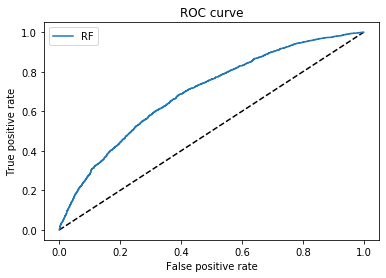

In [26]:
# CALCULATE precision and recall of the test set
# And plot the ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix


# Performance Metrics
y_pred_rf = model.predict_proba(X_train)[:, 1]
y_pred = model.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred)) # confusion_matrix - y_train, y_pred

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.53      0.57       934
           1       0.67      0.73      0.70      1183

    accuracy                           0.65      2117
   macro avg       0.64      0.63      0.63      2117
weighted avg       0.64      0.65      0.64      2117

Confusion Matrix
[[499 435]
 [316 867]]

Accuracy
0.6452527161076995


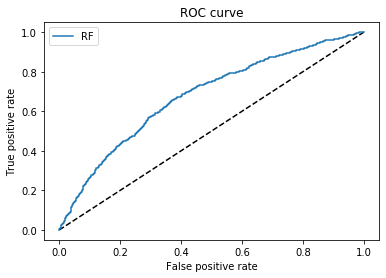

In [27]:
# Performance Metrics
y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))    # classification_report

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred)) # confusion_matrix - y_test, y_pred

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [28]:
combined_data['Predicted_Signal'] = model.predict(X)
combined_data['Original_SP_returns'] = combined_data['return']
Cumulative_originalSP500_returns = np.cumsum(combined_data[split:]['Original_SP_returns']).apply(np.exp)
combined_data['Strategy_Returns'] = combined_data['Original_SP_returns']* combined_data['Predicted_Signal']
Cumulative_Strategy_returns = np.cumsum(combined_data[split:]['Strategy_Returns']).apply(np.exp)

newdf = pd.concat([Cumulative_originalSP500_returns, Cumulative_Strategy_returns], axis=1)

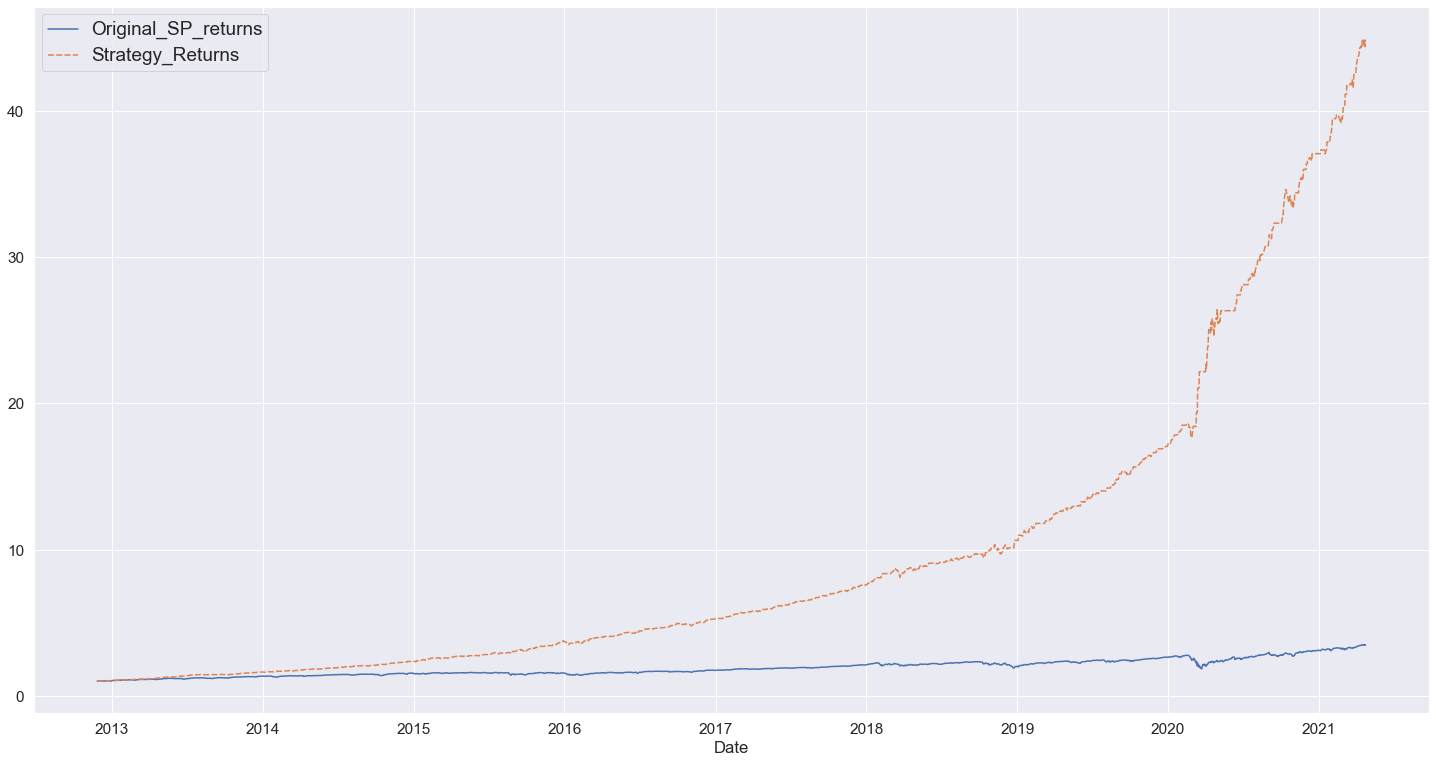

In [29]:
#Graph plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
 
plt.figure(figsize=(25, 13))
sns.set(font_scale=1.4) 
ax = sns.lineplot(data=newdf)
plt.setp(ax.get_legend().get_texts(), fontsize='19')
plt.savefig('returns.png', dpi=300)

In [30]:
#import pyfolio as pf
#%matplotlib inline

## silence warnings
#import warnings
#warnings.filterwarnings('ignore')

In [31]:
#meta_returns = combined_data['Strategy_Returns'].loc['20130102':]
#pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)

In [32]:
from sklearn.model_selection import StratifiedKFold

# stratified K-fold is splits the data in 10 folds 
# and plots individual and the overall ROC curve.

from scipy import interp
from sklearn.metrics import auc


def crossValPlot(skf,classifier,X_,y_):
    """Code adapted from:
        
    """
    
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))

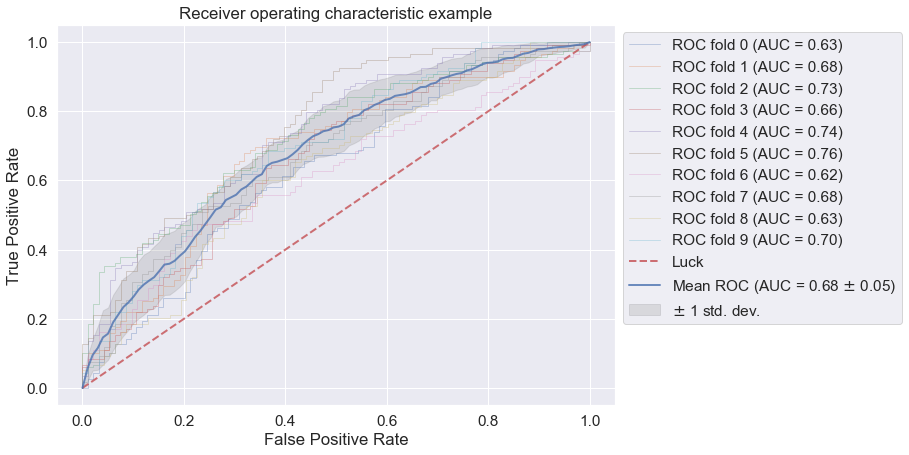

In [33]:
skf = StratifiedKFold(n_splits=10, shuffle=False)
model = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=10000)
crossValPlot(skf,model,X_test,y_test)